In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random

import matplotlib.pyplot as plt

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

In [45]:
seed = 42
feature_size = 18
baseline_accuracy = 0.875

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

random.seed(seed)
torch_seed = random.randint(0, 2 ** 32 - 1)
numpy_seed = random.randint(0, 2 ** 32 - 1)
torch.manual_seed(torch_seed)
torch.cuda.manual_seed(torch_seed)
np.random.seed(numpy_seed)

Using device: cuda


In [46]:
class SigmoidNeuralNetwork(nn.Module):
    def __init__(self, input_size: int, layer_size: int = 64):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 1),
        )

    def forward(self, x):
        return self.layers(x).view(-1)
    
    def clasiffy(self, x):
        return torch.round(nn.Sigmoid()(self.forward(x))).view(-1).long()

In [47]:
def load_data(feature_size: int):
    X = np.load('../Datasets/kryptonite-%s-X.npy'%(feature_size))
    y = np.load('../Datasets/kryptonite-%s-y.npy'%(feature_size))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    knn = KMeans(n_clusters=2, random_state=seed, n_init="auto").fit(X_train)

    X_train = np.concatenate((X_train, knn.predict(X_train).reshape(-1, 1)), axis=1)
    X_test = np.concatenate((X_test, knn.predict(X_test).reshape(-1, 1)), axis=1)

    return X_train, y_train, X_test, y_test

In [55]:
X_train, y_train, X_test, y_test = load_data(feature_size)

print(X_train.shape)

(28800, 19)


In [56]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size+1,
    device=device,
)

params = {
    'optimizer__lr': [0.1, 0.01, 0.001],
    'max_epochs': [50],
    'batch_size': [4096],
    'module__layer_size': [128],
    'optimizer__weight_decay': [1e-3],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=2)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 3 candidates, totalling 30 fits


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1319, in fit
    self.partial_fit(X, y, **fit_params)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1278, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1190, in fit_loop
    self.run_single_epoch(iterator_train, training=True, prefix="train",
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1226, in run_single_epoch
    step = step_fn(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1105, in train_step
    self._step_optimizer(step_fn)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1060, in _step_optimizer
    optimizer.step(step_fn)
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\optim\optimizer.py", line 487, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\optim\optimizer.py", line 91, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\optim\adam.py", line 202, in step
    loss = closure()
           ^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1094, in step_fn
    step = self.train_step_single(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 993, in train_step_single
    y_pred = self.infer(Xi, **fit_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\skorch\net.py", line 1521, in infer
    return self.module_(x, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Mihai\AppData\Local\Temp\ipykernel_20516\3968590140.py", line 14, in forward
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\container.py", line 250, in forward
    input = module(input)
            ^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mihai\miniconda3\Lib\site-packages\torch\nn\modules\linear.py", line 125, in forward
    return F.linear(input, self.weight, self.bias)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float


In [ ]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 4096, 'max_epochs': 50, 'module__layer_size': 128, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.7841666666666665


In [ ]:
from skorch.callbacks import EpochScoring

net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=gs.best_params_['optimizer__lr'],
    optimizer__weight_decay=gs.best_params_['optimizer__weight_decay'],
    batch_size=1024,
    module__input_size=feature_size,
    device=device,
    callbacks=[
        EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
    ],
)

net = net.fit(X_train, y_train.astype(float))

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.4984        0.6947       0.4976        0.6932  1.0105
      2       0.4998        0.6932       0.5038        0.6932  0.6400
      3       0.5071        0.6931       0.5005        0.6931  0.7279
      4       0.5035        0.6931       0.4991        0.6931  0.9789
      5       0.5048        0.6930       0.5016        0.6932  0.6298
      6       0.5061        0.6930       0.5031        0.6932  0.6366
      7       0.5076        0.6930       0.5056        0.6931  0.6670
      8       0.5057        0.6930       0.5071        0.6932  0.6412
      9       0.5083        0.6930       0.5017        0.6931  0.6737
     10       0.5072        0.6929       0.5030        0.6931  0.6434
     11       0.5083        0.6929       0.5083        0.6930  0.6273
     12       0.5210        0.6924       0.5552        0.6916  0.6571
     13       0.5780

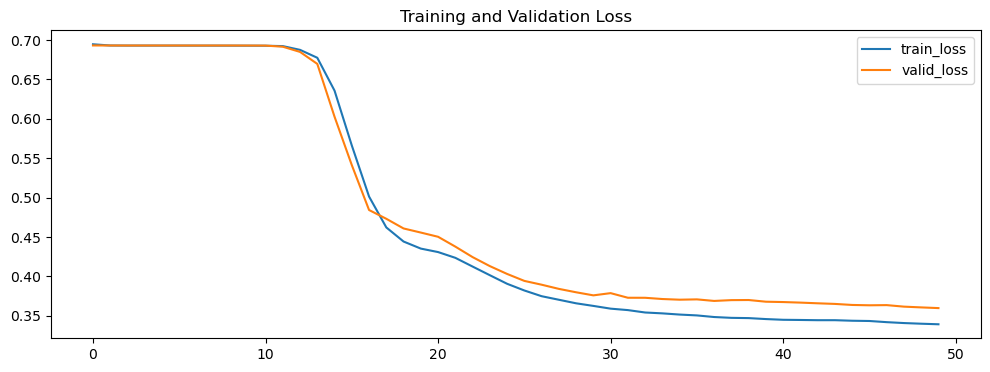

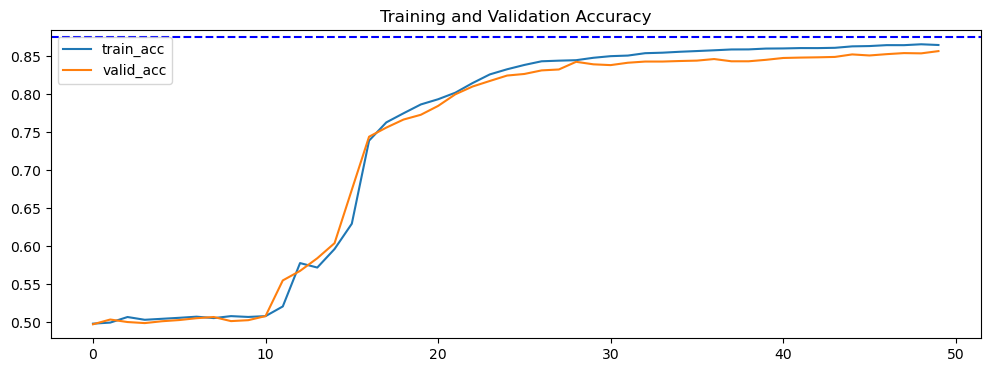

In [ ]:
train_loss = net.history[:, 'train_loss']
valid_loss = net.history[:, 'valid_loss']

train_acc = net.history[:, 'train_acc']
valid_acc = net.history[:, 'valid_acc']

plt.figure(figsize=(12, 4))
plt.plot(train_loss, label='train_loss')
plt.plot(valid_loss, label='valid_loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(train_acc, label='train_acc')
plt.plot(valid_acc, label='valid_acc')
plt.axhline(y=baseline_accuracy, color='b', linestyle='--')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()
